In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import h5py
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [2]:
Images_Path = "/home/arnabdey/Placement_ML_projects/.vscode/Kaggle cancer images/isic-2024-challenge/train-image/image"
all_files = pd.read_csv("/home/arnabdey/Placement_ML_projects/.vscode/Kaggle cancer images/isic-2024-challenge/train-metadata.csv")
test_files = pd.read_csv("/home/arnabdey/Placement_ML_projects/.vscode/Kaggle cancer images/isic-2024-challenge/test-metadata.csv")
print(len(os.listdir(Images_Path)))

/tmp/ipykernel_7252/2622661652.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  all_files = pd.read_csv("/home/arnabdey/Placement_ML_projects/.vscode/Kaggle cancer images/isic-2024-challenge/train-metadata.csv")


464725


In [27]:
# all_files.info()

In [3]:
all_data = all_files.drop(columns=[
    "tbp_lv_location_simple",
    "tbp_lv_dnn_lesion_confidence", 
    "mel_thick_mm",
    "mel_mitotic_index",
    "iddx_1", "iddx_2", "iddx_3", "iddx_4", "iddx_5", "iddx_full",
    "lesion_id",
    "image_type",
    "tbp_tile_type",
    "attribution",
    "copyright_license",
    "patient_id"
    ])

In [29]:
nan_counts = all_data.isnull().sum()
print(f"Columns with no of nan values, out of {len(all_data)}")
print(nan_counts[nan_counts != 0])

Columns with no of nan values, out of 401059
age_approx              2798
sex                    11517
anatom_site_general     5756
dtype: int64


In [30]:
# unique_vals = all_data["anatom_site_general"].unique()
# print(len(unique_vals))
# print(unique_vals)

In [31]:
all_data["age_approx"] = all_data["age_approx"].fillna(-10.0)
all_data["sex"] = all_data["sex"].replace({'male' : 0, 'female' : 1}).fillna(-1.0)
all_data["anatom_site_general"] = all_data["anatom_site_general"].replace({
    'lower extremity' : 0,
    'head/neck' : 1,
    'posterior torso' : 2,
    'anterior torso' : 3,
    'upper extremity' : 4
}).fillna(-1)
unique_vals = all_data["tbp_lv_location"].unique()
# print(len(unique_vals))
myDict = {}
i = 0
for x in unique_vals:
    myDict[x] = i
    i += 1
all_data["tbp_lv_location"] = all_data["tbp_lv_location"].replace(myDict)

one_data = {}
for index, row in all_data.iterrows():
    for key in row.keys():
        one_data[key] = row[key]
    break
one_data["isic_id"] = "hello"
print(one_data)

In [61]:
count = 0
prev_one_data = all_data[all_data["target"] == 1]
all_data_zeros = all_data[all_data["target"] == 0]
all_data_ones = pd.DataFrame(columns=all_data.columns)

for index, row in tqdm(prev_one_data.iterrows()):
    #augment this image
    image = cv2.imread(Images_Path + "/" + row["isic_id"] + ".jpg")
    list_of_images = [image]

    list_of_images.append(image[:-1])
    list_of_images.append(image[1:])
    list_of_images.append(image[:,:-1])
    list_of_images.append(image[:,1:])

    list_of_images.append(image[:-2])
    list_of_images.append(image[2:])
    list_of_images.append(image[:,:-2])
    list_of_images.append(image[:,2:])

    new_list = [x for x in list_of_images]
    for x in list_of_images:
        new_list.append(np.clip(x-1, 0, 255))
        new_list.append(np.clip(x+1, 0, 255))
    del list_of_images
    list_of_images = [x for x in new_list]
    for x in new_list:
        list_of_images.append(cv2.rotate(x, cv2.ROTATE_180))
        list_of_images.append(cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE))
        list_of_images.append(cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE))
        list_of_images.append(cv2.flip(x, 0))
        list_of_images.append(cv2.flip(x, 1))
    
    i = 0
    for x in list_of_images:
        #save the image in folder
        name = row["isic_id"] + str(i)
        i += 1
        output_path = Images_Path + "/" + name + ".jpg"
        cv2.imwrite(output_path, x)
        #add the new row in csv file
        one_data = {}
        for key in row.keys():
            one_data[key] = row[key]
        one_data["isic_id"] = name
        # print(one_data)
        # break
        new_row = pd.DataFrame(one_data, index=[count])
        count += 1
        all_data_ones = pd.concat([all_data_ones, new_row])      
        
    # break

393it [03:54,  1.68it/s]


In [62]:
all_data_zeros.to_csv("all_data_zeros.csv")
all_data_ones.to_csv("all_data_ones.csv")

In [63]:
checkOne = pd.read_csv("/home/arnabdey/Placement_ML_projects/.vscode/Kaggle cancer images/all_data_ones.csv")

In [65]:
print(all_data_ones["isic_id"][1])

ISIC_00828291


In [66]:
print(len(all_data_zeros))
print(len(all_data_ones))

401059
400666
63666


*Now data is cleaned*

In [3]:
all_data_ones = pd.read_csv("/home/arnabdey/Placement_ML_projects/.vscode/Kaggle cancer images/all_data_ones.csv")
all_data_zeros = pd.read_csv("/home/arnabdey/Placement_ML_projects/.vscode/Kaggle cancer images/all_data_zeros.csv")
all_data_ones = all_data_ones.drop(columns=["Unnamed: 0"])
all_data_zeros = all_data_zeros.drop(columns=["Unnamed: 0"])

In [5]:
train_size_ones = int(0.8 * len(all_data_ones))
train_size_zeros = int(0.8 * len(all_data_zeros))

train_data_ones = all_data_ones[:train_size_ones]
train_data_zeros = all_data_zeros[:train_size_zeros]

val_data_ones = all_data_ones[train_size_ones:]
val_data_zeros = all_data_zeros[train_size_zeros:]

print(f"No of train images = {len(train_data_ones)}, {len(train_data_zeros)}")
print(f"No of validation images = {len(val_data_ones)}, {len(val_data_zeros)}")

No of train images = 50932, 320532
No of validation images = 12734, 80134


**The Model image to classification : 0/1**

In [3]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.CNN = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(8),
            nn.GELU(),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.GELU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(32), 
            nn.GELU(),

            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.GELU(),

            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(8),
            nn.GELU(),

            nn.Conv2d(in_channels=8, out_channels=4, kernel_size=5, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(4),
            nn.GELU(),

            nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.GELU()
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=961 + 37, out_features=200, bias=True),
            nn.GELU(),
            nn.Linear(in_features=200, out_features=128, bias=True),
            nn.GELU(),
            nn.Linear(in_features=128, out_features=128, bias=True),
            nn.GELU(),
            nn.Linear(in_features=128, out_features=32, bias=True),
            nn.GELU(),
            nn.Linear(in_features=32, out_features=8, bias=True),
            nn.GELU(),
            nn.Linear(in_features=8, out_features=2, bias=True),
            # nn.Sigmoid()
        )

    def forward(self, x, attributes):

        x = torch.moveaxis(x, 3, 1)
        cnn_output = self.CNN(x)
        flattened = cnn_output.reshape(x.shape[0], -1)
        #flattened shape is ( , 961)
        full_data = torch.cat((flattened, attributes), dim=1)
        return self.fc(full_data)

In [4]:
model = Classifier()
model = torch.compile(model).to('cuda')
torch.set_float32_matmul_precision('high')
torch._dynamo.config.suppress_errors = True

batch_size = 256
epochs = 30
optimiser = optim.AdamW(model.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.5794, 3.6466], device='cuda'))

In [97]:
# a = torch.zeros((32, 300, 125, 3), dtype = float)
# a = torch.moveaxis(a, 3, 1)
# print(a.shape)

In [98]:
losses = []
for epoch in range(epochs):
    print(f"epoch : {epoch+1} / {epochs} ")
    epoch_loss = 0
    for i in tqdm(range(1450 + 1)):
        
        if(i == 1450):# the last batch has 82(zero types) and 182(one types)
            zero_data = all_data_zeros[-82:]
            one_data = all_data_ones[-182:]
        else:# take 35 one-types, 221 zero-types.
            zero_data = all_data_zeros[i * 221 : (i + 1) * 221]
            one_data =  all_data_ones[i * 35 : (i + 1) * 35]
        images_in_batch = []

        for name in zero_data["isic_id"]:
            path_to_image = Images_Path + "/" + name + ".jpg"
            images_in_batch.append(cv2.resize(cv2.imread(path_to_image) / 255.0, (300, 300)))
        for name in one_data["isic_id"]:
            path_to_image = Images_Path + "/" + name + ".jpg"
            images_in_batch.append(cv2.resize(cv2.imread(path_to_image) / 255.0, (300, 300)))
        attr_zeros = torch.tensor(zero_data.drop(columns=["isic_id", "target"]).values, dtype=torch.float32)
        attr_ones =  torch.tensor(one_data.drop(columns=["isic_id", "target"]).values, dtype=torch.float32)
        attr = torch.cat((attr_zeros, attr_ones), dim=0).to('cuda')

        targets_zeros = torch.tensor(zero_data["target"].values, dtype=torch.int32)
        targets_ones  = torch.tensor(one_data["target"].values, dtype=torch.int32)
        targets = torch.cat((targets_zeros, targets_ones), dim=0).to('cuda')


        images_in_batch = np.array(images_in_batch)

        tensor_data = torch.tensor(images_in_batch, dtype=torch.float32, device='cuda')
        tensor_targets = torch.zeros((targets.shape[0], 2), dtype=torch.float32, device='cuda')
        tensor_targets[torch.arange(targets.shape[0]), targets] = 1

        optimiser.zero_grad()
        outputs = model(tensor_data, attr)
        loss = criterion(outputs, tensor_targets)
        # losses.append(loss.item())
        epoch_loss += loss.item()
        loss.backward()
        optimiser.step()    
    losses.append(epoch_loss / 1451.0)

epoch : 1 / 30 


100%|██████████| 1451/1451 [18:07<00:00,  1.33it/s]


epoch : 2 / 30 


100%|██████████| 1451/1451 [17:21<00:00,  1.39it/s]


epoch : 3 / 30 


100%|██████████| 1451/1451 [17:21<00:00,  1.39it/s]


epoch : 4 / 30 


100%|██████████| 1451/1451 [17:27<00:00,  1.39it/s]


epoch : 5 / 30 


100%|██████████| 1451/1451 [17:30<00:00,  1.38it/s]


epoch : 6 / 30 


100%|██████████| 1451/1451 [17:24<00:00,  1.39it/s]


epoch : 7 / 30 


100%|██████████| 1451/1451 [17:23<00:00,  1.39it/s]


epoch : 8 / 30 


100%|██████████| 1451/1451 [17:24<00:00,  1.39it/s]


epoch : 9 / 30 


100%|██████████| 1451/1451 [17:23<00:00,  1.39it/s]


epoch : 10 / 30 


100%|██████████| 1451/1451 [17:25<00:00,  1.39it/s]


epoch : 11 / 30 


100%|██████████| 1451/1451 [17:28<00:00,  1.38it/s]


epoch : 12 / 30 


100%|██████████| 1451/1451 [17:24<00:00,  1.39it/s]


epoch : 13 / 30 


100%|██████████| 1451/1451 [17:25<00:00,  1.39it/s]


epoch : 14 / 30 


100%|██████████| 1451/1451 [17:19<00:00,  1.40it/s]


epoch : 15 / 30 


100%|██████████| 1451/1451 [16:45<00:00,  1.44it/s]


epoch : 16 / 30 


100%|██████████| 1451/1451 [16:46<00:00,  1.44it/s]


epoch : 17 / 30 


100%|██████████| 1451/1451 [16:45<00:00,  1.44it/s]


epoch : 18 / 30 


100%|██████████| 1451/1451 [17:15<00:00,  1.40it/s]


epoch : 19 / 30 


100%|██████████| 1451/1451 [17:10<00:00,  1.41it/s]


epoch : 20 / 30 


100%|██████████| 1451/1451 [17:24<00:00,  1.39it/s]


epoch : 21 / 30 


100%|██████████| 1451/1451 [17:24<00:00,  1.39it/s]


epoch : 22 / 30 


100%|██████████| 1451/1451 [17:18<00:00,  1.40it/s]


epoch : 23 / 30 


100%|██████████| 1451/1451 [17:20<00:00,  1.39it/s]


epoch : 24 / 30 


100%|██████████| 1451/1451 [17:17<00:00,  1.40it/s]


epoch : 25 / 30 


100%|██████████| 1451/1451 [17:22<00:00,  1.39it/s]


epoch : 26 / 30 


100%|██████████| 1451/1451 [17:20<00:00,  1.39it/s]


epoch : 27 / 30 


100%|██████████| 1451/1451 [17:14<00:00,  1.40it/s]


epoch : 28 / 30 


100%|██████████| 1451/1451 [17:15<00:00,  1.40it/s]


epoch : 29 / 30 


100%|██████████| 1451/1451 [17:17<00:00,  1.40it/s]


epoch : 30 / 30 


100%|██████████| 1451/1451 [17:22<00:00,  1.39it/s]


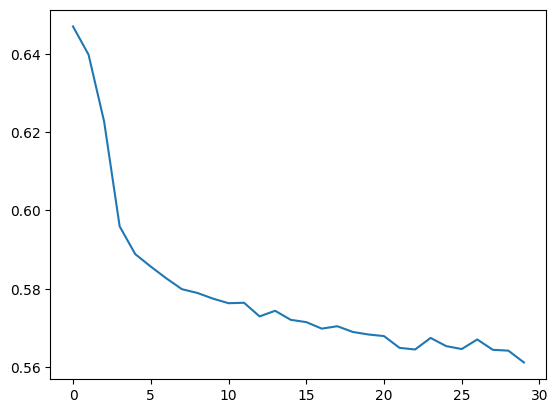

In [99]:
plt.plot(losses)
plt.show()

In [5]:
# torch.save(model.state_dict(), "/home/arnabdey/Placement_ML_projects/.vscode/Kaggle cancer images/chall_model.pt")
# model = Classifier()
model.load_state_dict(torch.load("/home/arnabdey/Placement_ML_projects/.vscode/Kaggle cancer images/chall_model.pt"))

<All keys matched successfully>

Check on Validation Data

In [8]:
All_outputs = []
All_targets = []
batch_size = 256
with torch.no_grad():
    
    for i in tqdm(range(0, len(val_data_ones), batch_size)):
        images_in_batch = []

        for name in val_data_ones["isic_id"][i:i+batch_size]:
            path_to_image = Images_Path + "/" + name + ".jpg"
            
            images_in_batch.append(cv2.resize(cv2.imread(path_to_image) / 255.0, (300, 300)))

        attr = torch.tensor(val_data_ones[i:i+batch_size].drop(columns = ["isic_id", "target"]).values, dtype=torch.float32, device='cuda')
            
        images_in_batch = np.array(images_in_batch)
        tensor_data = torch.tensor(images_in_batch, dtype=torch.float32, device='cuda')
        targets = np.array(val_data_ones[i:i+batch_size]["target"].values, dtype=float)

        All_targets.append(targets)
        All_outputs.append(model(tensor_data, attr).detach().to('cpu').numpy())
    
    for i in tqdm(range(0, len(val_data_zeros), batch_size)):
        images_in_batch = []

        for name in val_data_zeros["isic_id"][i:i+batch_size]:
            path_to_image = Images_Path + "/" + name + ".jpg"
            
            images_in_batch.append(cv2.resize(cv2.imread(path_to_image) / 255.0, (300, 300)))

        attr = torch.tensor(val_data_zeros[i:i+batch_size].drop(columns = ["isic_id", "target"]).values, dtype=torch.float32, device='cuda')
            
        images_in_batch = np.array(images_in_batch)
        tensor_data = torch.tensor(images_in_batch, dtype=torch.float32, device='cuda')
        targets = np.array(val_data_zeros[i:i+batch_size]["target"].values, dtype=float)

        All_targets.append(targets)
        All_outputs.append(model(tensor_data, attr).detach().to('cpu').numpy())

100%|██████████| 314/314 [02:42<00:00,  1.93it/s]


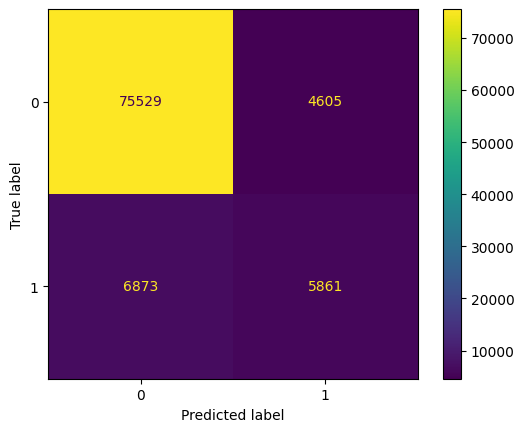

In [21]:
all_outs = []
for i in range(len(All_outputs)):
    for x in All_outputs[i]:
        all_outs.append(x)
all_outs = np.array(all_outs)
all_outs_max = np.array([np.exp(x) / np.sum(np.exp(x)) for x in all_outs])
all_outs_int = np.array([np.argmax(x) for x in all_outs])
all_targets = []
for i in range(len(All_targets)):
    for x in All_targets[i]:
        all_targets.append(x)
all_targets = np.array(all_targets)

c_matrix = confusion_matrix(y_true=all_targets, y_pred=all_outs_int)
accu = accuracy_score(y_true=all_targets, y_pred=all_outs_int)
f1 = f1_score(y_true=all_targets, y_pred=all_outs_int)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
disp.plot()
plt.show()

In [10]:
print(f"Accuracy = {accu}")
print(f"F1 Score = {f1}")

Accuracy = 0.8764052203127018
F1 Score = 0.5052586206896552


In [24]:
print(all_outs_max[:, 0].shape)

(92868,)


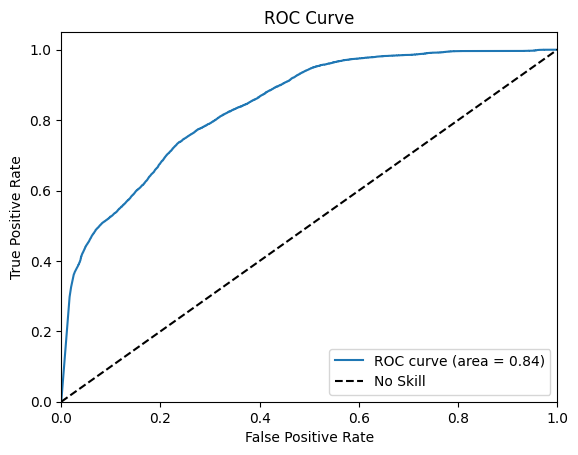

In [26]:
fpr, tpr, thresholds = roc_curve(all_targets, all_outs_max[:, 1]) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Testing
---------

In [7]:
import h5py

test_data = test_files.drop(columns=[
    "tbp_lv_location_simple",
    "image_type",
    "tbp_tile_type",
    "attribution",
    "copyright_license",
    "patient_id"
    ])
test_names = []
with h5py.File('/home/arnabdey/Placement_ML_projects/.vscode/Kaggle cancer images/isic-2024-challenge/test-image.hdf5', 'r') as f:
    for group_name in f.keys():
        test_names.append(group_name)

In [8]:
test_data["age_approx"] = test_data["age_approx"].fillna(-10.0)
test_data["sex"] = test_data["sex"].replace({'male' : 0, 'female' : 1}).fillna(-1.0)
test_data["anatom_site_general"] = test_data["anatom_site_general"].replace({
    'lower extremity' : 0,
    'head/neck' : 1,
    'posterior torso' : 2,
    'anterior torso' : 3,
    'upper extremity' : 4
}).fillna(-1)
unique_vals = test_data["tbp_lv_location"].unique()
# print(len(unique_vals))
myDict = {}
i = 0
for x in unique_vals:
    myDict[x] = i
    i += 1
test_data["tbp_lv_location"] = test_data["tbp_lv_location"].replace(myDict)

In [8]:
attr_ones =  torch.tensor(all_data_ones.drop(columns=["isic_id", "target"]).values, dtype=torch.float32)
test_attr = torch.tensor(test_data.drop(columns=["isic_id"]).values, dtype=torch.float32)

In [33]:
Images_Path = "/home/arnabdey/Placement_ML_projects/.vscode/Kaggle cancer images/isic-2024-challenge/train-image/image"
outputs = []
batch_size = 32
for i in tqdm(range(0,len(all_data_zeros), batch_size)):

    list_of_images = []
    for name in all_data_zeros["isic_id"][i : i + batch_size]:

        path = Images_Path + "/" + name + ".jpg"        
        image = cv2.resize(cv2.imread(path) / 255.0, (300, 300))
        list_of_images.append(image)
    test_images = np.array(list_of_images, dtype = float)
    test_images = torch.tensor(test_images, dtype=torch.float32, device='cuda')
    test_attr = torch.tensor(all_data_zeros[i : i+batch_size].drop(columns=["isic_id", "target"]).values, dtype=torch.float32, device='cuda')
    break
    with torch.no_grad():
        output = torch.softmax(model(test_images, test_attr), dim=1).detach().cpu().numpy()
    for o in output[:, 1]:
        outputs.append(o)


  0%|          | 0/12521 [00:00<?, ?it/s]

(300, 300, 3)


In [34]:
outputs = []
batch_size = 32
for i in range(0, len(test_names), batch_size):
    names = test_names[i : i + batch_size]
    list_of_images = []
    list_of_attrs = []

    for name in names:
        path = Images_Path + "/" + name + ".jpg"        
        # print(path)
    #     image = cv2.resize(cv2.imread(path) / 255.0, (300, 300))
        image = np.random.randn(300, 300, 3)
        list_of_images.append(image)
        list_of_attrs.append(test_data[test_data["isic_id"] == name].drop(columns=["isic_id"]).values)

    test_images = np.array(list_of_images, dtype = float)
    test_images = torch.tensor(test_images, dtype=torch.float32, device='cuda')
    test_attr = np.array(list_of_attrs, dtype = float).reshape(-1, 37)
    test_attr = torch.tensor(test_attr, dtype=torch.float32, device='cuda')
    
    with torch.no_grad():
        output = torch.softmax(model(test_images, test_attr), dim=1).detach().cpu().numpy()
    for o in output[:, 1]:
        outputs.append(o)

In [35]:
print(outputs)

[1.3862583e-12, 4.6192614e-16, 1.879104e-14]


In [40]:
Data = {
    "isic_id" : [name for name in test_names],
    "target"  : [probability for probability in outputs]
    }
df = pd.DataFrame(Data)
df.to_csv("mySampleSubmission.csv", index=False)

In [41]:
d = pd.read_csv("/home/arnabdey/Placement_ML_projects/.vscode/Kaggle cancer images/mySampleSubmission.csv")
print(d.head())

        isic_id        target
0  ISIC_0015657  1.386258e-12
1  ISIC_0015729  4.619261e-16
2  ISIC_0015740  1.879104e-14


Using HDF5
---

In [78]:
import io
from PIL import Image
image_names = list(f.keys())

In [79]:
f = h5py.File("/home/arnabdey/Placement_ML_projects/.vscode/Kaggle cancer images/isic-2024-challenge/test-image.hdf5", 'r')

outputs = []
batch_size = 32
for i in range(0, len(image_names), batch_size):

    list_of_images = []
    list_of_attrs = []
    for name in image_names[i : i + batch_size]:
        x = f[name][()]
        image = cv2.resize(np.array(Image.open(io.BytesIO(x)), dtype = float) / 255.0, (300, 300))
        list_of_images.append(image)
        list_of_attrs.append(test_data[test_data["isic_id"] == name].drop(columns = ["isic_id"]).values)

    list_of_images = np.array(list_of_images, dtype = float)
    list_of_attrs = np.array(list_of_attrs, dtype = float).reshape(-1, 37)

    list_of_images = torch.tensor(list_of_images, dtype=torch.float32, device='cuda')
    list_of_attrs = torch.tensor(list_of_attrs, dtype=torch.float32, device='cuda')

    with torch.no_grad():
        output = torch.softmax(model(list_of_images, list_of_attrs), dim=1).detach().cpu().numpy()
    for o in output[:, 1]:
        outputs.append(o)

In [9]:
import h5py
import numpy as np
import torch
import cv2
from PIL import Image
import io
from torch.utils.data import DataLoader, Dataset
import concurrent.futures

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, image_names, hdf5_file, test_data):
        self.image_names = image_names
        self.f = hdf5_file
        self.test_data = test_data

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        name = self.image_names[idx]
        x = self.f[name][()]
        image = cv2.resize(np.array(Image.open(io.BytesIO(x)), dtype=float) / 255.0, (300, 300))
        attrs = self.test_data[self.test_data["isic_id"] == name].drop(columns=["isic_id"]).values
        return image, attrs

# Load data in parallel
def load_data_parallel(image_names, f, test_data, batch_size):
    dataset = CustomDataset(image_names, f, test_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=8, pin_memory=True)
    return dataloader

# Optimized test loop
# f = h5py.File("/kaggle/input/isic-2024-challenge/test-image.hdf5", 'r')
f = h5py.File("/home/arnabdey/Placement_ML_projects/.vscode/Kaggle cancer images/isic-2024-challenge/test-image.hdf5", 'r')

image_names = list(f.keys())

batch_size = 512
dataloader = load_data_parallel(image_names, f, test_data, batch_size)

outputs = []
model.to('cuda')
model.eval()

# Optional: Mixed precision
scaler = torch.cuda.amp.autocast()

with torch.no_grad():
    for batch in dataloader:
        list_of_images, list_of_attrs = batch
        list_of_images = torch.tensor(list_of_images, dtype=torch.float32, device='cuda')
        list_of_attrs = torch.tensor(list_of_attrs, dtype=torch.float32, device='cuda').reshape(-1, 37)

        with torch.cuda.amp.autocast():
            output = torch.softmax(model(list_of_images, list_of_attrs), dim=1).detach().cpu().numpy()

        outputs.extend(output[:, 1].tolist())

f.close()

/tmp/ipykernel_7252/1316586501.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_of_images = torch.tensor(list_of_images, dtype=torch.float32, device='cuda')
/tmp/ipykernel_7252/1316586501.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_of_attrs = torch.tensor(list_of_attrs, dtype=torch.float32, device='cuda').reshape(-1, 37)


In [11]:
model = torch.compile(model)